In [3]:
%pylab inline

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/home/hq/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
wage = pd.read_csv('WAG_C_M_jan19.csv', sep=';', index_col='month', parse_dates=True, dayfirst=True)
wage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 1993-01-01 to 2019-01-01
Data columns (total 1 columns):
WAG_C_M    313 non-null float64
dtypes: float64(1)
memory usage: 4.9 KB


Посмотрим на наш ряд и на его свойства.

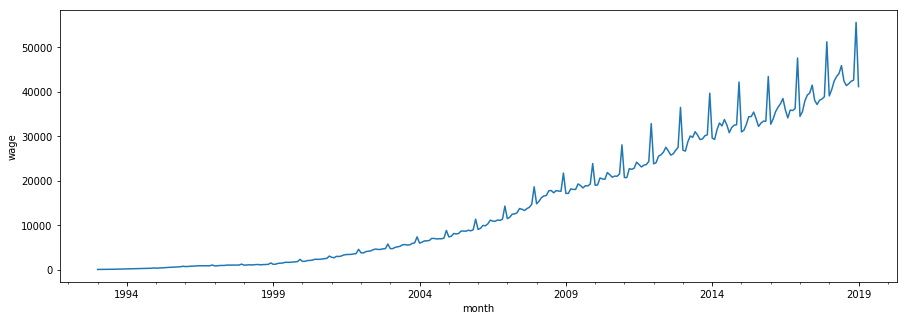

In [5]:
plt.figure(figsize(15,5))
wage.WAG_C_M.plot()
plt.ylabel('wage')
pylab.show()

Т.о. имеем:
    
-повышающийся тренд

-годовая сезонность

-автокоррелированность.

Помимо этого, дисперсия нестационарна, растет с течением времени.

Проверим на стационарность с помощью критерия Дики-Фулера (хотя на графике и так очевидно, что наш ряд сейчас не стационарный)
И сделаем STL декомпозицию, посмотрим на свойства по отдельности.

достигаемый уровень значимости для критерия Д-Ф: p=0.998345


<Figure size 1080x720 with 0 Axes>

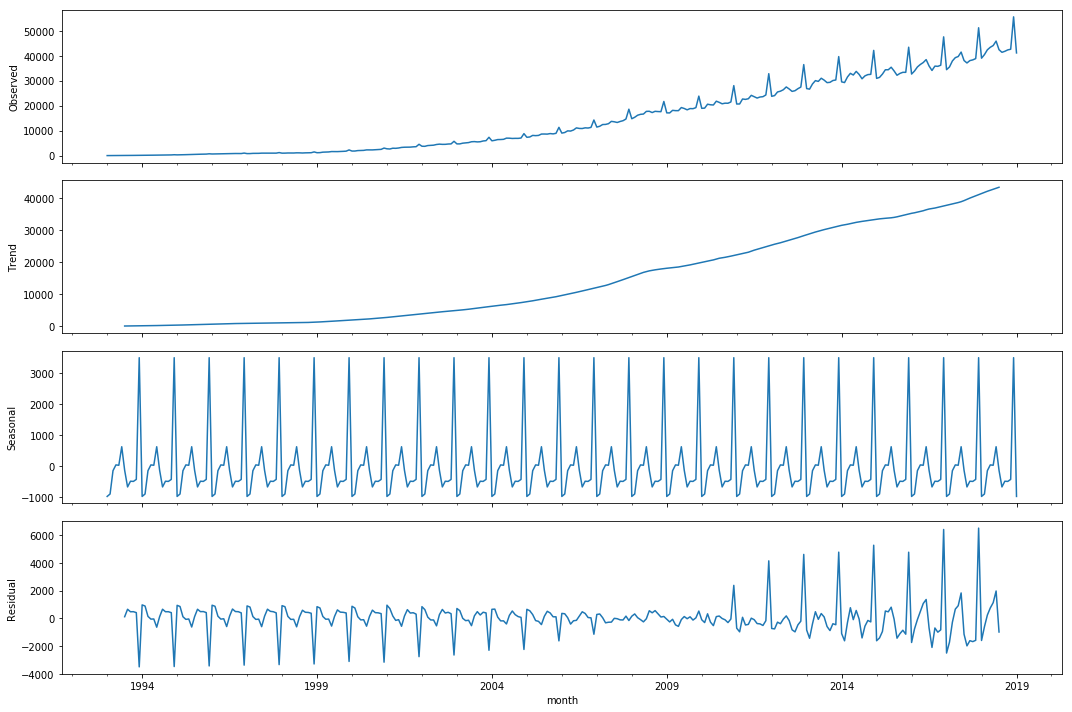

In [6]:
print("достигаемый уровень значимости для критерия Д-Ф: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot();

Тренд и сезонность выражены очень явно, далее попробуем стабилизировать дисперсию и придать ряду стационарность с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.283080
достигаемый уровень значимости для критерия Д-Ф: p=0.695803


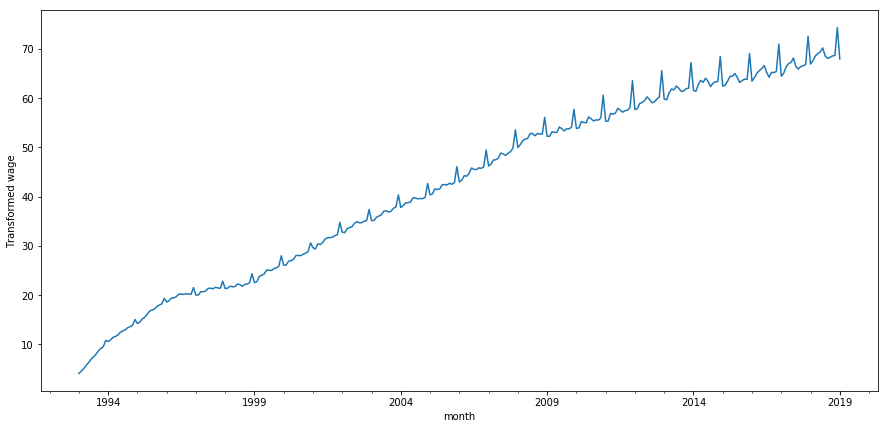

In [7]:
wage['wage_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.wage_box.plot()
plt.ylabel('Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("достигаемый уровень значимости для критерия Д-Ф: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

Намного лучше, но нулевая гипотеза о нестационарности все еще не отвергается, теперь сделаем сезонное дифференцирование и проверим на стационарность.

достигаемый уровень значимости для критерия Д-Ф: p=0.161068


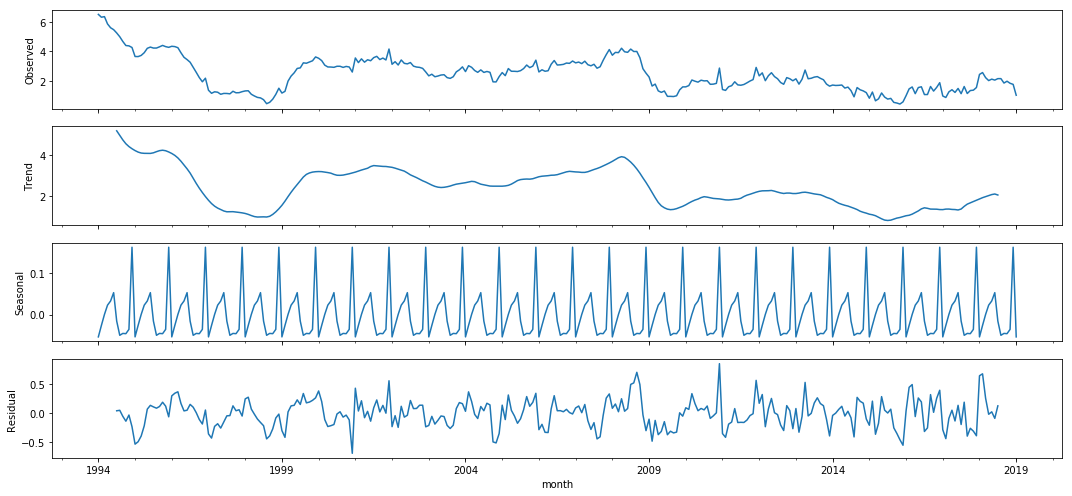

In [8]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12)
_ = sm.tsa.seasonal_decompose(wage.wage_box_diff.dropna()).plot()
print('достигаемый уровень значимости для критерия Д-Ф: p=%f' % sm.tsa.stattools.adfuller(wage.wage_box_diff.dropna())[1])

Мы все еще не можем отвергнуть нулевую гипотезу + на графике виден тренд. Попробуем применить обычное дифференцирование, посмотрим на результат.

достигаемый уровень значимости для критерия Д-Ф: p=0.000000


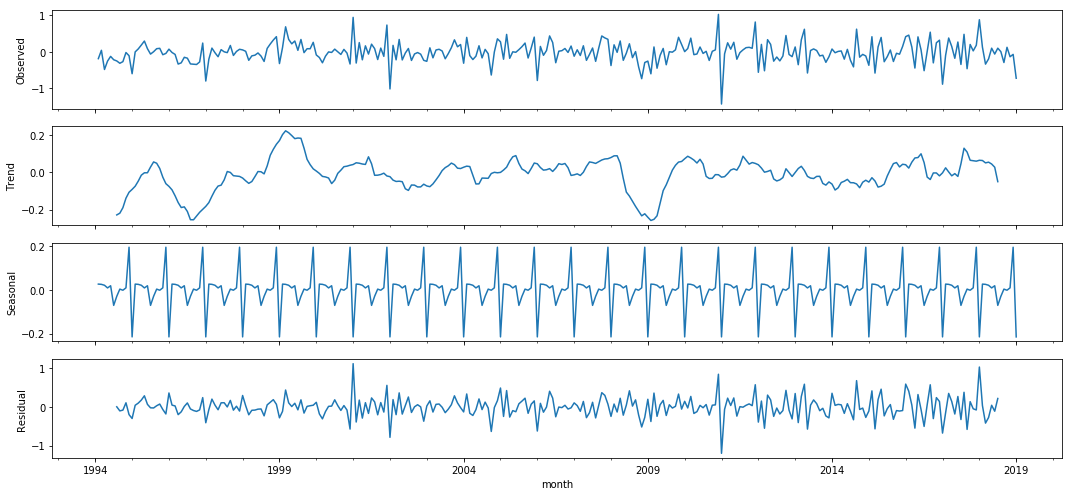

In [9]:
wage['wage_box_norm_diff'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
_ = sm.tsa.seasonal_decompose(wage.wage_box_norm_diff.dropna()).plot()
print('достигаемый уровень значимости для критерия Д-Ф: p=%f' % sm.tsa.stattools.adfuller(wage.wage_box_norm_diff.dropna())[1])

С уверенностью можно сказать, что ряд является стационарным.

Построим графики автокорелляции и частичной автокорелляции для полученного ряда, чтобы выбрать начальные приближения параметров нашей прогнозирующей модели.

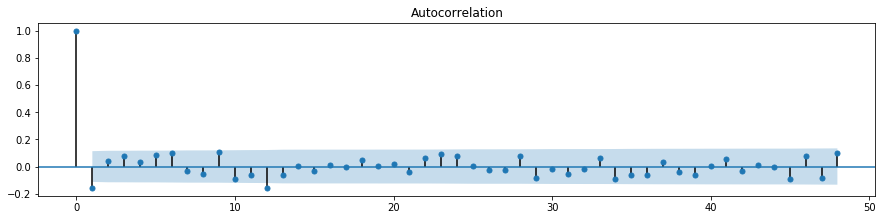

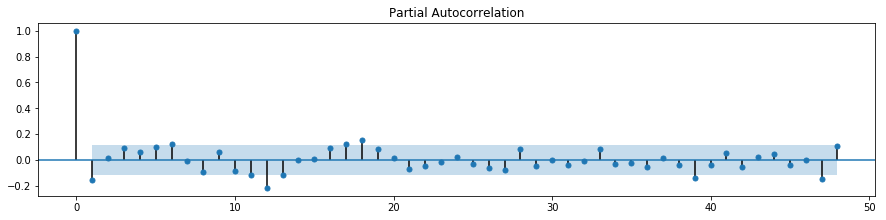

In [10]:
plt.figure(figsize(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_norm_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_norm_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Q = 1 (видим значимый лаг на 12), q = 1 (хотя судя по графику оптимальное значение вполне может быть и 0)
P = 1 (аналогично, видим явный сезонный лаг на 12), p = 1(но точно так же вполне может быть оптимальным значением и 0, дальше будем проверять)

In [11]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Количество вариантв параметров: %f" % len(parameters_list))

Количество вариантв параметров: 16.000000


In [13]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

/home/hq/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/hq/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/hq/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/hq/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

CPU times: user 8.95 s, sys: 31.8 ms, total: 8.98 s
Wall time: 2.65 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
11  (1, 0, 1, 1)  113.855984
7   (0, 1, 1, 1)  114.370841
10  (1, 0, 1, 0)  115.780792
15  (1, 1, 1, 1)  115.803158
6   (0, 1, 1, 0)  116.425084


In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  313
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -52.928
Date:                            Sun, 24 Feb 2019   AIC                            113.856
Time:                                    23:54:22   BIC                            128.671
Sample:                                01-01-1993   HQIC                           119.785
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1977      0.045     -4.384      0.000      -0.286      -0.109
ar.S.L12      -0.7447      0.124   

Теперь взглянем на остатки модели, посмотрим на их свойства и на то, насколько они похожи на белый шум.

t-критерий Стьюдента: p=0.169733
Критерий Дики-Фуллера: p=0.000036


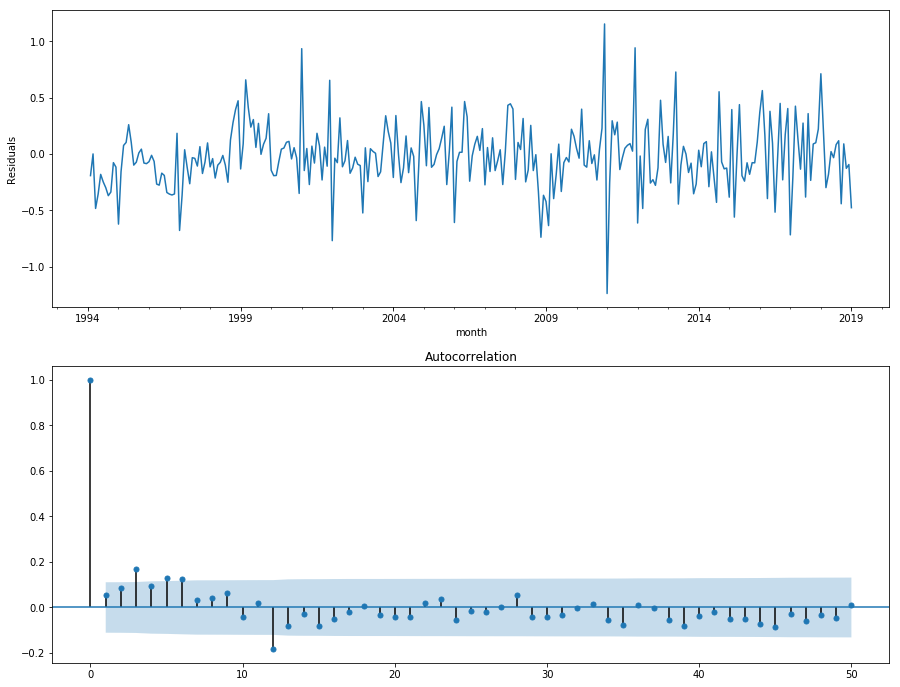

In [16]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(211)
_ = best_model.resid[13:].plot()
_ = plt.ylabel(u'Residuals')

_ = ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("t-критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки стационарны, несмещенные, какую-либо дополнительную информацию сложно разглядеть. Это хорошо.

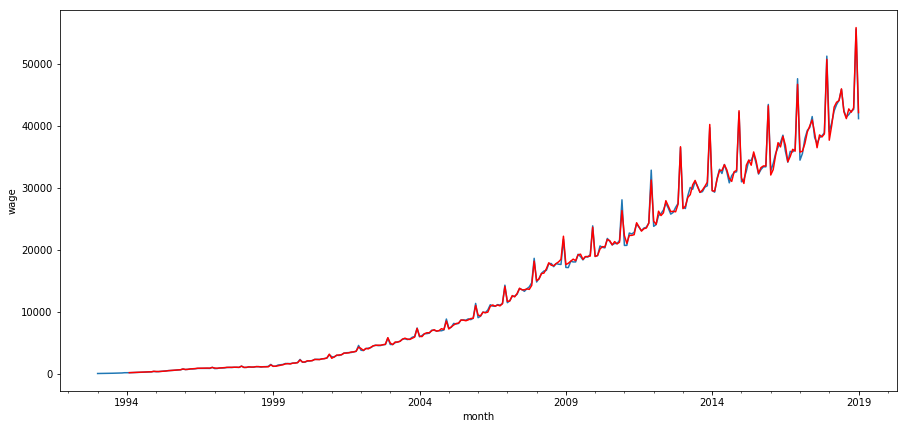

In [17]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('wage')
pylab.show()

Модель описывает данные весьма и весьма точно, ну а теперь попробуем спрогнозировать наши с вами зарплаты на ближайшие 2 года. 

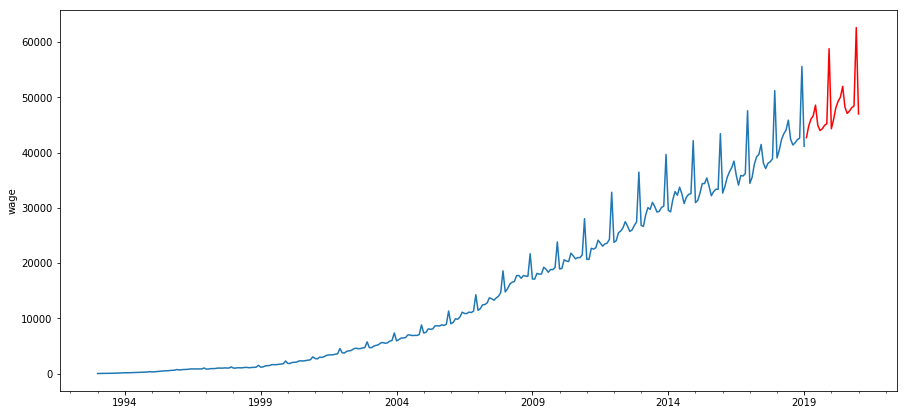

In [18]:
wage2 = wage[['WAG_C_M']]
start = wage.shape[0]
date_list = [datetime.datetime.strptime("2019-02-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=start, end=start+24), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('wage')
pylab.show()

Выглядит вполне правдоподобно и адекватно.

In [19]:
wage2.tail(24)

,WAG_C_M,forecast
2019-02-01,NaN,42690.857417
2019-03-01,NaN,44806.600311
2019-04-01,NaN,46047.769140
2019-05-01,NaN,46668.673486
2019-06-01,NaN,48569.903438
2019-07-01,NaN,44946.519057
2019-08-01,NaN,43973.838872
2019-09-01,NaN,44304.815589
2019-10-01,NaN,44918.344921
2019-11-01,NaN,45213.078897
